In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kabilan03/dogbreedclassification")

print("Path to dataset files:", path)

100%|██████████| 272M/272M [00:02<00:00, 142MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/kabilan03/dogbreedclassification/versions/3


In [ ]:
import os
ne = os.listdir(path)
os.path.join(path,ne[0])
new = (os.path.join(path,ne[0]))
new

'/root/.cache/kagglehub/datasets/kabilan03/dogbreedclassification/versions/3/Dog Breed Classification'

In [ ]:
from tensorflow import image
from torch.utils.data import DataLoader,Dataset
from torchvision import transforms
import os
from PIL import Image

class ImageDataset(Dataset):
    def __init__(self,image_dir,transform=None):
      self.image_dir = image_dir

      self.transform = transform
      self.image =[]
      self.labels = []

      for i ,class_name in enumerate(sorted(os.listdir(self.image_dir))):
        class_path = os.path.join(self.image_dir,class_name)

        if not os.path.isdir(class_path):
                continue
        for image_path in os.listdir(class_path):
          self.image.append(os.path.join(class_path,image_path))
          self.labels.append(i)


    def __len__(self):
      return len(self.image)

    def __getitem__(self,idx):
      image_path = self.image[idx]
      label = self.labels[idx]
      img = Image.open(image_path).convert("RGB")
      # print(img.size)

      if self.transform:
        img = self.transform(img)


      return img,label





In [ ]:
def get_activation(name):
    if name.lower() == "relu":
        return nn.ReLU(inplace=True)
    elif name.lower() == "leakyrelu":
        return nn.LeakyReLU(0.1, inplace=True)
    elif name.lower() == "elu":
        return nn.ELU(inplace=True)
    else:
        raise ValueError(f"Unsupported activation: {name}")


In [ ]:

import torch.nn as nn
import torch
class FlexibleCNN(nn.Module):

      def __init__(self,
                   in_channels:int = 3,
                   num_class :int = 93,
                   conv_layers = [64, 128, 256, 512,512],
                   kernels_sizes =[3,3,3,3,3],
                   activation = 'relu',
                   dense_layer = 286,
                   input_size =224,
                   dp_con =0.1
                   ,dp_fc = 0.01
      ):
        super().__init__()
        assert len(conv_layers) == 5
        assert len(kernels_sizes) == 5
        self.activation =get_activation(activation)

        layers =[]

        prev_channel = in_channels
        for out_channel ,k  in zip(conv_layers,kernels_sizes):
              layers.append(
                  nn.Conv2d(prev_channel,out_channel,k,padding=k//2)
              )
              layers.append(nn.BatchNorm2d(out_channel))
              layers.append(self.activation)
              layers.append(nn.MaxPool2d(2,2))
              layers.append(nn.Dropout(dp_con))
              prev_channel = out_channel

        self.conv = torch.nn.Sequential(*layers)

        with torch.no_grad():
          dummy = torch.zeros(1,in_channels,input_size,input_size)
          conv_out = self.conv(dummy)
          self.flatten_dim = conv_out.view(1,-1).shape[1]

        self.fc1 = nn.Linear(self.flatten_dim,dense_layer)
        self.bc_fc = nn.BatchNorm1d(dense_layer)
        self.dp_fc = nn.Dropout(dp_fc)
        self.fc2 = nn.Linear(dense_layer,num_class)




      def forward(self, x):
          x = self.conv(x)
          x = torch.flatten(x, start_dim=1)

          x = self.fc1(x)
          x = self.bc_fc(x)
          x = self.activation(x)
          x = self.dp_fc(x)
          x = self.fc2(x)
          return x






In [ ]:
def accuracy(output,target):
  predict = torch.argmax(output,dim=1)
  correct =(predict == target).sum().item()
  return correct/len(target)

In [ ]:
def train(model,train_loader,optimizer,criterio,device):
      model.train()

      running_loss =0
      running_acc = 0
      total_sample =0

      for images , labels in train_loader:
        images,labels = images.to(device),labels.to(device)

        optimizer.zero_grad()

        output = model(images)
        loss =criterio(output,labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() *labels.size(0)
        running_acc += accuracy(output,labels) *labels.size(0)
        total_sample += len(labels)

      epoch_loss = running_loss / total_sample
      epoch_acc = running_acc / total_sample
      return epoch_loss,epoch_acc

def validate(model,val_loader,criterio,device):
      model.eval()

      running_loss =0
      running_acc = 0
      total_sample =0

      with torch.no_grad():
        for images ,labels in val_loader:
          images,labels = images.to(device),labels.to(device)
          output = model(images)

          loss = criterio(model(images),labels)

          running_loss += loss.item() *labels.size(0)
          running_acc += accuracy(output,labels) *labels.size(0)
          total_sample += len(labels)
      total_loss = running_loss / total_sample
      epoch_acc = running_acc / total_sample
      return total_loss,epoch_acc






In [ ]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(), # Moved ToTensor before Normalize
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

train_dataset = ImageDataset(
    image_dir="/root/.cache/kagglehub/datasets/kabilan03/dogbreedclassification/versions/3/Dog Breed Classification/train",
    transform=transform
)

val_dataset = ImageDataset(
    image_dir ="/root/.cache/kagglehub/datasets/kabilan03/dogbreedclassification/versions/3/Dog Breed Classification/val",
    transform=transform
)

# print(len(train_dataset))
img, label = train_dataset[69]
print(label,img)

0 tensor([[[ 0.8789,  0.8104,  0.7933,  ...,  0.8447,  0.8276,  0.7933],
         [ 0.7762,  0.7077,  0.7077,  ...,  0.7419,  0.7077,  0.6906],
         [ 0.8276,  0.7591,  0.7419,  ...,  0.7419,  0.6734,  0.8447],
         ...,
         [-0.0972, -0.1314,  0.1768,  ...,  0.0569, -0.0801, -0.2171],
         [-0.0801, -0.0972,  0.5022,  ..., -0.1657, -0.0458, -0.0287],
         [ 0.1597,  0.1254,  0.2796,  ..., -0.1486,  0.2111,  0.2967]],

        [[ 1.5007,  1.4307,  1.4307,  ...,  1.4307,  1.2731,  1.0630],
         [ 1.3782,  1.3081,  1.3081,  ...,  1.3431,  1.1506,  0.9755],
         [ 1.4132,  1.3431,  1.3431,  ...,  1.3081,  1.1155,  1.1331],
         ...,
         [ 0.2752,  0.1352,  0.2752,  ...,  0.4328,  0.2402,  0.0826],
         [ 0.2927,  0.2052,  0.7129,  ...,  0.2227,  0.3277,  0.3452],
         [ 0.5203,  0.4153,  0.5203,  ...,  0.2577,  0.6254,  0.7304]],

        [[ 2.1346,  2.0823,  2.0648,  ...,  1.9428,  1.6291,  1.2805],
         [ 2.0300,  1.9603,  1.9428,  ..., 

In [ ]:
from torch.utils.data import DataLoader

loader_train = DataLoader(
    train_dataset,
    batch_size=10,
    shuffle=True,
    drop_last=True
)



loader_val = DataLoader(
    val_dataset,
    batch_size=10,
    shuffle=True,
    drop_last=True
)



In [ ]:



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Fix: Initialize FlexibleCNN with the correct input_size (32) to match image preprocessing.
model = FlexibleCNN(input_size=32,dp_con=0.15,dp_fc=0.3)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr= 1e-4)

history ={
    "train_loss":[],
    "train_acc":[],
    "val_loss":[],
    "val_acc":[]

}

for epoch in range(20):
  train_loss,train_acc = train(model,loader_train,optimizer,criterion,device)
  val_loss,val_acc = validate(model,loader_val,criterion,device)

  history["train_loss"].append(train_loss)
  history["train_acc"].append(train_acc)

  history["val_loss"].append(val_loss)
  history["val_acc"].append(val_acc)

  print(f"Epoch {epoch+1}/{15} | ")
  print(f"Train Loss: {train_loss:.4f} , Train Acc: {train_acc:.4f}")
  print(f"Val Loss: {val_loss:.4f} , Val Acc: {val_acc:.4f}") # Corrected to use val_loss and val_acc

Epoch 13/15 | 
Train Loss: 2.9999 , Train Acc: 0.2674
Val Loss: 3.4819 , Val Acc: 0.1553
Epoch 14/15 | 
Train Loss: 2.8634 , Train Acc: 0.3053
Val Loss: 3.4586 , Val Acc: 0.1737
Epoch 15/15 | 
Train Loss: 2.6909 , Train Acc: 0.3473
Val Loss: 3.4678 , Val Acc: 0.1566
Epoch 16/15 | 
Train Loss: 2.5700 , Train Acc: 0.3731
Val Loss: 3.4733 , Val Acc: 0.1737
Epoch 17/15 | 
Train Loss: 2.3651 , Train Acc: 0.4299
Val Loss: 3.4637 , Val Acc: 0.1855
Epoch 18/15 | 
Train Loss: 2.2084 , Train Acc: 0.4689
Val Loss: 3.5132 , Val Acc: 0.1618
Epoch 19/15 | 
Train Loss: 2.0511 , Train Acc: 0.5056
Val Loss: 3.5002 , Val Acc: 0.1776
Epoch 20/15 | 
Train Loss: 1.8753 , Train Acc: 0.5607
Val Loss: 3.5248 , Val Acc: 0.1789


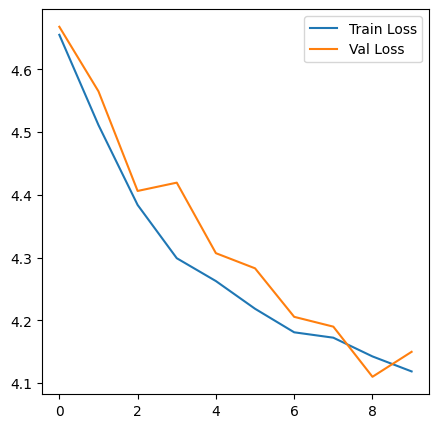

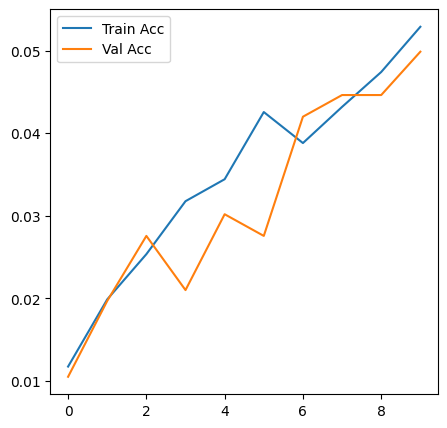

In [ ]:
  from matplotlib import pyplot as plt

plt.figure(figsize=(5,5))
plt.plot(history["train_loss"],label="Train Loss")

plt.plot(history["val_loss"],label="Val Loss")
plt.legend()
plt.show()


plt.figure(figsize=(5,5))
plt.plot(history["train_acc"],label="Train Acc")

plt.plot(history["val_acc"],label="Val Acc")
plt.legend()
plt.show()